<a href="https://colab.research.google.com/github/aserdargun/DSML101/blob/main/tensorflow/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leverageing a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems to our own.
2. Can leverage a working nerual network architectue which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

In [1]:
# Are we using a GPU?
!nvidia-smi

Sat Sep 16 10:05:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-09-16 10:05:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  20.9MB/s    in 8.7s    

2023-09-16 10:05:58 (18.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames, in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

There are 2 directories and 0 images in '10_food_classes_10_percent
There are 10 directories and 0 images in '10_food_classes_10_percent/train
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza
There are

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (thing to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint wiyh the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Ym%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

> ⌨ **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following featue vector model link: https://tfhub.dev/google/efficientnet/b0/feature-vector/1

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [18]:
# Let's make a create_model() function to create a model from  aURL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str):A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and seave it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name="feature",
                                            input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
    return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [19]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [21]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [24]:
#Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/2023m16-102809
Epoch 1/5
24/24 [==============================] - 28s 558ms/step - loss: 2.0242 - accuracy: 0.3307 - val_loss: 1.2624 - val_accuracy: 0.5952
Epoch 2/5
24/24 [==============================] - 13s 546ms/step - loss: 0.9082 - accuracy: 0.7307 - val_loss: 0.8911 - val_accuracy: 0.7164
Epoch 3/5
24/24 [==============================] - 11s 463ms/step - loss: 0.6342 - accuracy: 0.8160 - val_loss: 0.7798 - val_accuracy: 0.7476
Epoch 4/5
24/24 [==============================] - 10s 446ms/step - loss: 0.4892 - accuracy: 0.8720 - val_loss: 0.7481 - val_accuracy: 0.7540
Epoch 5/5
24/24 [==============================] - 11s 477ms/step - loss: 0.3820 - accuracy: 0.9147 - val_loss: 0.6938 - val_accuracy: 0.7752


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time And with only 10% of the training examples.

In [27]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a sxript called "heper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
        history: TensorFlow History object.

    Returns:
        Plots of training/validation loss and accuracy metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

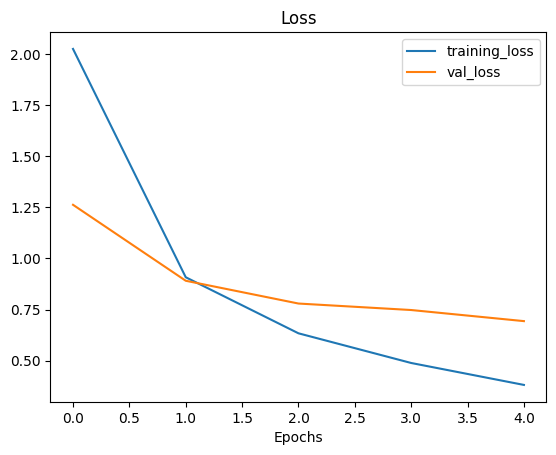

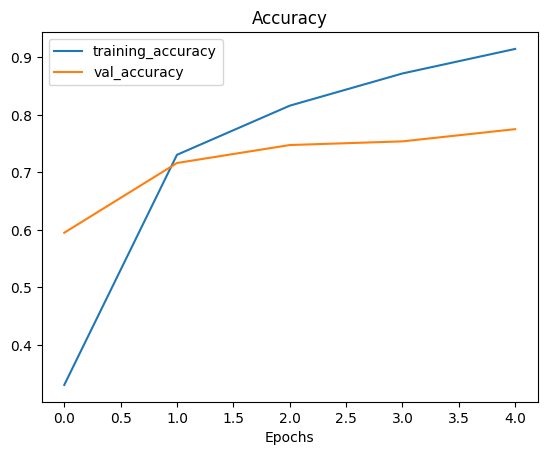

In [28]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensoFlow Hub Feature Extraction model

In [30]:
# Create EfficientNetB0 feature extractor model - details on EfficientNet: https://blog.research.google/2019/05/efficientnet-improving-accuracy-and.html?m=1
efficientnet_model = create_model(model_url=efficientnet_url,
                               num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

EPOCHS = 5

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/2023m16-111025
Epoch 1/5
24/24 [==============================] - 19s 605ms/step - loss: 1.8364 - accuracy: 0.4427 - val_loss: 1.2849 - val_accuracy: 0.7476
Epoch 2/5
24/24 [==============================] - 10s 439ms/step - loss: 1.0567 - accuracy: 0.7560 - val_loss: 0.8626 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 10s 448ms/step - loss: 0.7600 - accuracy: 0.8373 - val_loss: 0.6941 - val_accuracy: 0.8436
Epoch 4/5
24/24 [==============================] - 10s 408ms/step - loss: 0.6096 - accuracy: 0.8653 - val_loss: 0.6074 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 10s 429ms/step - loss: 0.5160 - accuracy: 0.8813 - val_loss: 0.5555 - val_accuracy: 0.8600


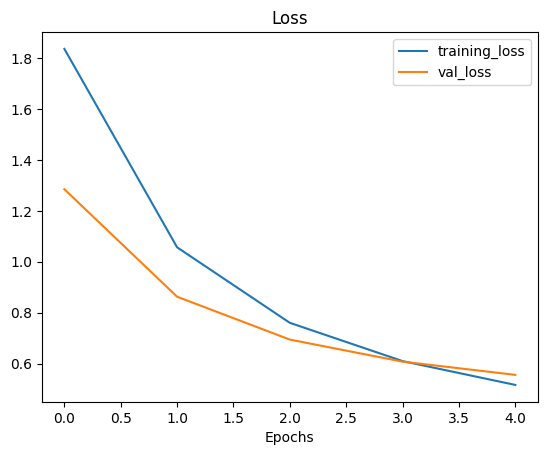

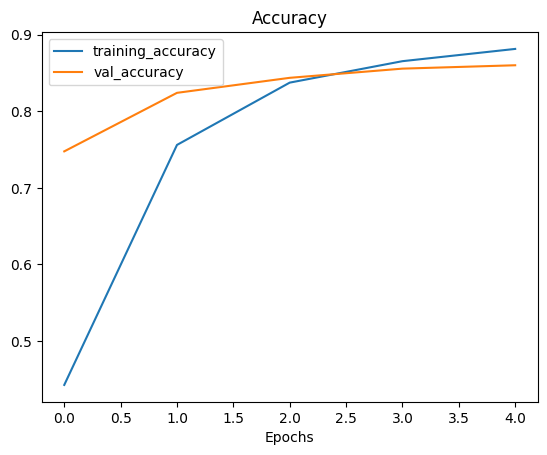

In [31]:
plot_loss_curves(efficientnet_history)

In [32]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature (KerasLayer)        (None, 1280)              4049564   
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [33]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature (KerasLayer)        (None, 2048)              23564800  
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [37]:
# How many layers does our efficientnetb0 feature extracto have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 Imagenet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> ⌨ **Note:** When you upload things to TensorBoard.dv, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev.

In [39]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. ResNet50V2" \
--description "Comparing two different TF Hub feature extraction model architecture using 10% of the training data" \
--one_shot

2023-09-16 11:43:24.120524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   VCQ-PSH-ZNK

VCQ-PSH-ZNK


New experiment created. View your TensorBoard at: https://tensor

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/1V8R0D4MTEG3RyGxPfReUw/


In [40]:
# Check out what TensorBoard you have
!tensorboard dev list

2023-09-16 11:52:15.548611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/1V8R0D4MTEG3RyGxPfReUw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   1V8R0D4MTEG3RyGxPfReUw
	Created              2023-09-16 11:44:50 (7 minutes ago)
	Updated              2023-09-16 11:44:55 (7 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3348334
Total: 1 experiment(s)


In [41]:
# Delete an experiment
# !tensorboard dev delete --experiment_id 1V8R0D4MTEG3RyGxPfReUw

In [42]:
# Confitm the deleyion by re-checking what experiments you have list
!tensorboard dev list

2023-09-16 11:54:29.526012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/1V8R0D4MTEG3RyGxPfReUw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   1V8R0D4MTEG3RyGxPfReUw
	Created              2023-09-16 11:44:50 (9 minutes ago)
	Updated              2023-09-16 11:44:55 (9 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3348334
Total: 1 experiment(s)
